    - [ ] flowchart of workflow
    - [ ] close up of valley reach (subbasin) on multidirectional hillshade
        - [ ] nhd flowline
        - [ ] corrected flowline
        - [ ] simplified flowline
        - [ ] cross sections
        - [ ] cross sections with peaks
        - [ ] cross sections with break points
        - [ ] hand at that threshold
        - [ ] filter with slope
    - [ ] cross section profile of elevation, 
        - [ ] with curvature, 
        - [ ] with peaks
        - [ ] and then break points highlighted

In [1]:
# use 180600060101 subbasin 45

In [1]:
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt

from valleys.utils import setup_wbt
from valleys.watershed import Watershed

In [2]:
dem_path = '../sampledata/180600060101/dem.tif'
nhd_flowlines_path = '../sampledata/180600060101/flowlines_mr.shp'

In [3]:
dem = rioxarray.open_rasterio(dem_path,masked=True).squeeze()
nhd = gpd.read_file(nhd_flowlines_path)

In [4]:
wbt = setup_wbt("~/opt/WBT/", "../data/figures/work_dir/")
watershed = Watershed(dem, nhd, '../data/figures/work_dir/')

In [5]:
watershed.process_watershed(wbt)

In [6]:
data, flowline = watershed.clip_to_subbasin(45)
nhd_flowline = nhd[nhd['OBJECTID'] == 2648071]
simplified = nhd_flowline.simplify(20)

In [7]:
import xrspatial
hillshade = xrspatial.hillshade(data['dem'])

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:23: RuntimeWarning: invalid value encountered in sin
  shaded = np.sin(altituderad) * np.sin(slope) + \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:24: RuntimeWarning: invalid value encountered in cos
  np.cos(altituderad) * np.cos(slope) * \
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xrspatial/hillshade.py:25: RuntimeWarning: invalid value encountered in cos
  np.cos((azimuthrad - np.pi/2.) - aspect)


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

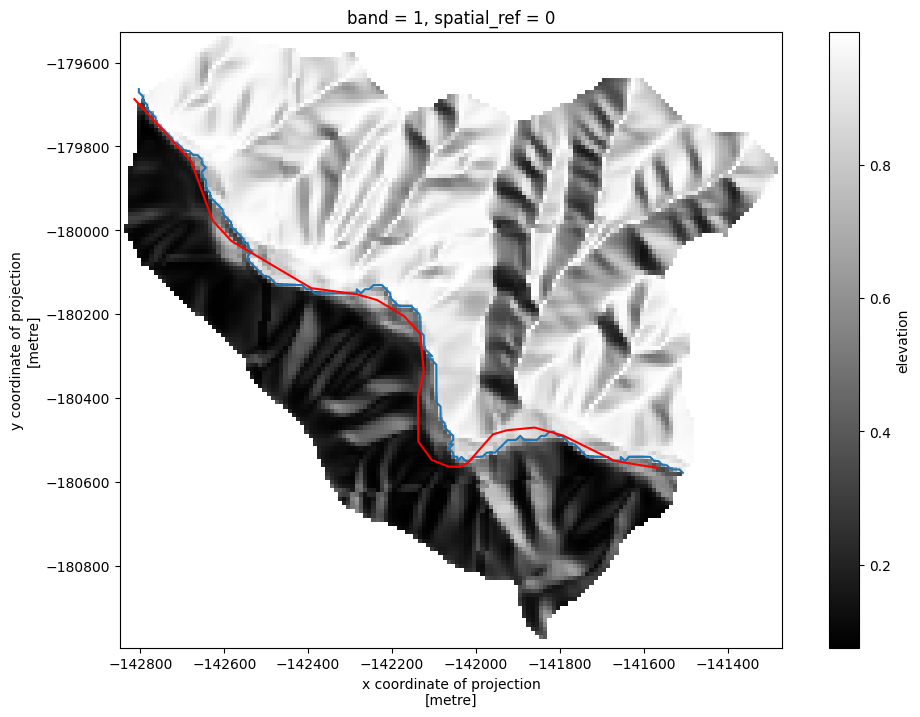

In [8]:
fig, ax = plt.subplots(figsize=(12,8))

hillshade.plot(ax=ax, cmap='gray')
gpd.GeoSeries(flowline, crs=3310).plot(ax=ax)
nhd_flowline.plot(ax=ax, color='red')
#simplified.plot(ax=ax, color='green')

In [9]:
from valleys.workflow import prep_dataset
from valleys.subbasin import Subbasin

subbasin_alternate = Subbasin(prep_dataset(data), flowline, 45)

In [10]:
subbasin_alternate.sample_cross_section_points(tolerance=20, xs_spacing=100, xs_width=300, xs_point_spacing=10)

In [11]:
subbasin_alternate.find_breakpoints(method='alternate')

In [12]:
subbasin_alternate.delineate_valley_floor()

In [13]:
# make lines for each cross section, start to end point
# get dataframe of peaks along the cross sections
# dataframe of break points = subbasin.break_points_df

<Axes: >

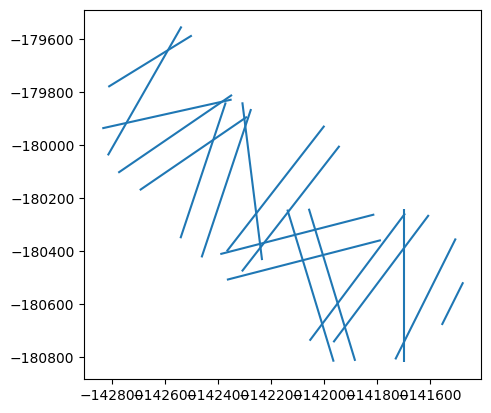

In [14]:
from shapely.geometry import LineString

grouped = subbasin_alternate.cross_sections_df.groupby('cross_section_id')

# Initialize an empty GeoDataFrame to store the resulting lines
lines = [] 

# Iterate over each group
for group_name, group_data in grouped:
    # Find the point with the highest and lowest alpha values
    max_alpha_point = group_data.loc[group_data['alpha'].idxmax()]
    min_alpha_point = group_data.loc[group_data['alpha'].idxmin()]
    
    # Create a LineString between the two points
    line = LineString([min_alpha_point.point, max_alpha_point.point])
    
    # Append the result to the lines GeoDataFrame
    lines.append({'cross_section_id': group_name, 'line': line})

# Convert lines_df to a GeoDataFrame
lines_gdf = gpd.GeoDataFrame(lines, geometry='line')

# Optionally, you can plot the resulting lines
lines_gdf.plot()

In [36]:
# for each line get the peaks
from valleys.breakpoints import find_xs_break_points_alternate, find_xs_break_points
import pandas as pd

peak_inds_list = []
for xs in subbasin_alternate.cross_sections_df['cross_section_id'].unique():
    xs_points = subbasin_alternate.cross_sections_df.loc[subbasin_alternate.cross_sections_df['cross_section_id'] == xs]
    peak_inds_list.append((xs, find_xs_break_points(xs_points, peak_threshold=0.002, slope_threshold=15)[-1]))
peak_inds = pd.DataFrame(peak_inds_list, columns=['xs_id', 'point_id'])

In [37]:
peak_inds = peak_inds.explode('point_id')
peaks = subbasin_alternate.cross_sections_df.loc[subbasin_alternate.cross_sections_df['point_id'].isin(peak_inds['point_id'])]

<Axes: >

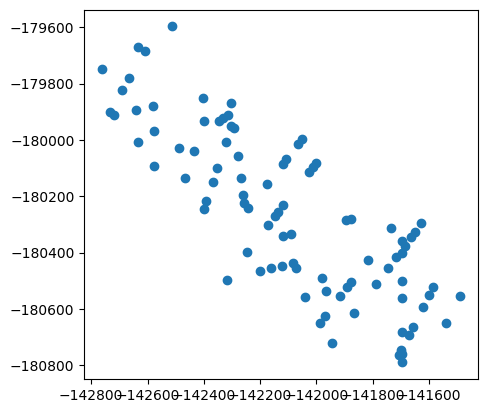

In [38]:
peaks.plot()

<Axes: >

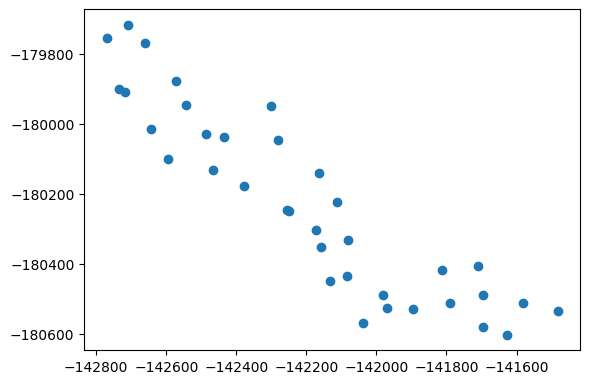

In [39]:
subbasin_alternate.break_points_df.plot()

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

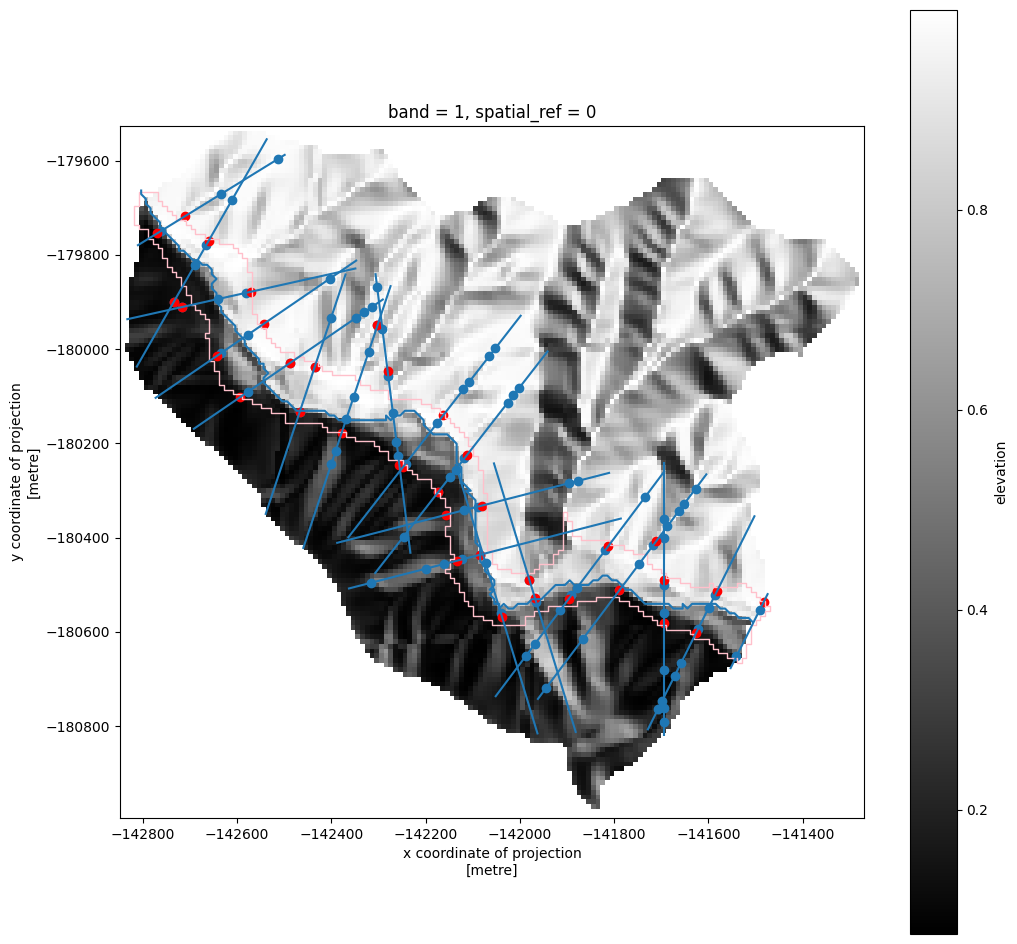

In [40]:
fig,ax = plt.subplots(figsize=(12,12))

hillshade.plot(ax=ax, cmap='grey')
#subbasin.dataset.slope.plot(ax=ax)
gpd.GeoSeries(flowline, crs=3310).plot(ax=ax)
peaks.plot(ax=ax)
lines_gdf.plot(ax=ax)
subbasin_alternate.break_points_df.plot(ax=ax, color='red')
gpd.GeoSeries(subbasin_alternate.valley_floor_polygon, crs=3310).plot(ax=ax, facecolor="none", edgecolor="pink")

<Axes: >

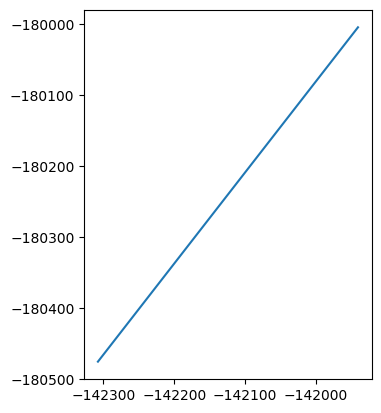

In [27]:
fig, ax = plt.subplots()
xs_id = 9
lines_gdf.loc[lines_gdf['cross_section_id'] == xs_id].plot(ax=ax)


In [28]:
peak_points = peaks.loc[peaks['cross_section_id'] == xs_id]
break_points = subbasin_alternate.break_points_df.loc[subbasin_alternate.break_points_df['cross_section_id'] == xs_id]
points = subbasin_alternate.cross_sections_df.loc[subbasin_alternate.cross_sections_df['cross_section_id'] == xs_id]

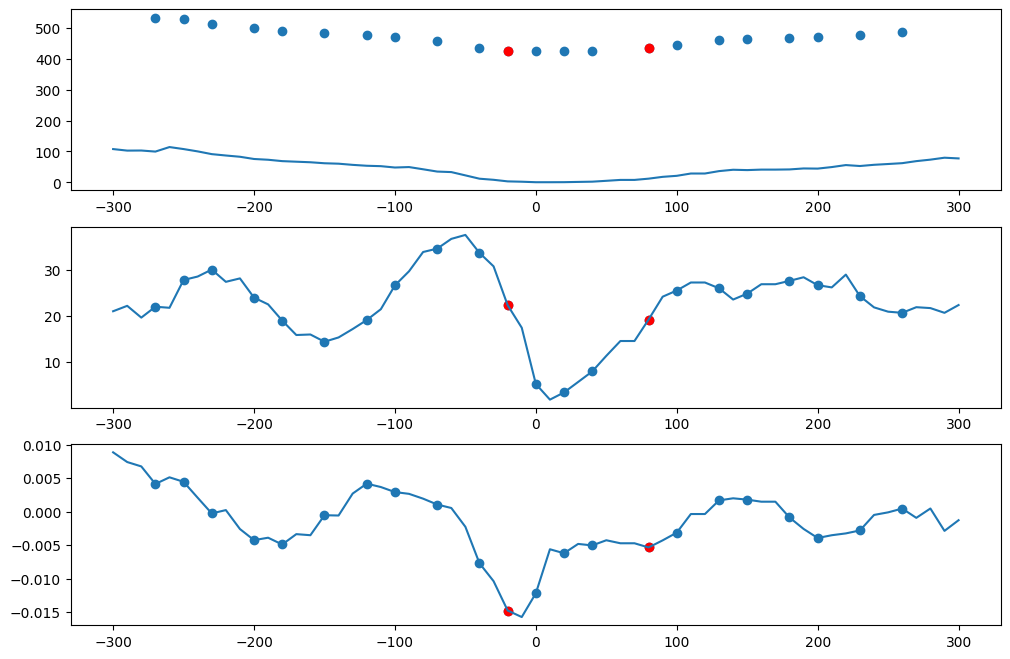

In [30]:
fig, ax = plt.subplots(3,1, figsize=(12,8))

ax[0].plot(points['alpha'], points['hand'])
ax[0].scatter(peak_points['alpha'], peak_points['elevation'])
ax[0].scatter(break_points['alpha'], break_points['elevation'], color='red')

ax[1].plot(points['alpha'], points['slope'])
ax[1].scatter(peak_points['alpha'], peak_points['slope'])
ax[1].scatter(break_points['alpha'], break_points['slope'], color='red')

ax[2].plot(points['alpha'], points['curvature'])
ax[2].scatter(peak_points['alpha'], peak_points['curvature'])
ax[2].scatter(break_points['alpha'], break_points['curvature'], color='red')

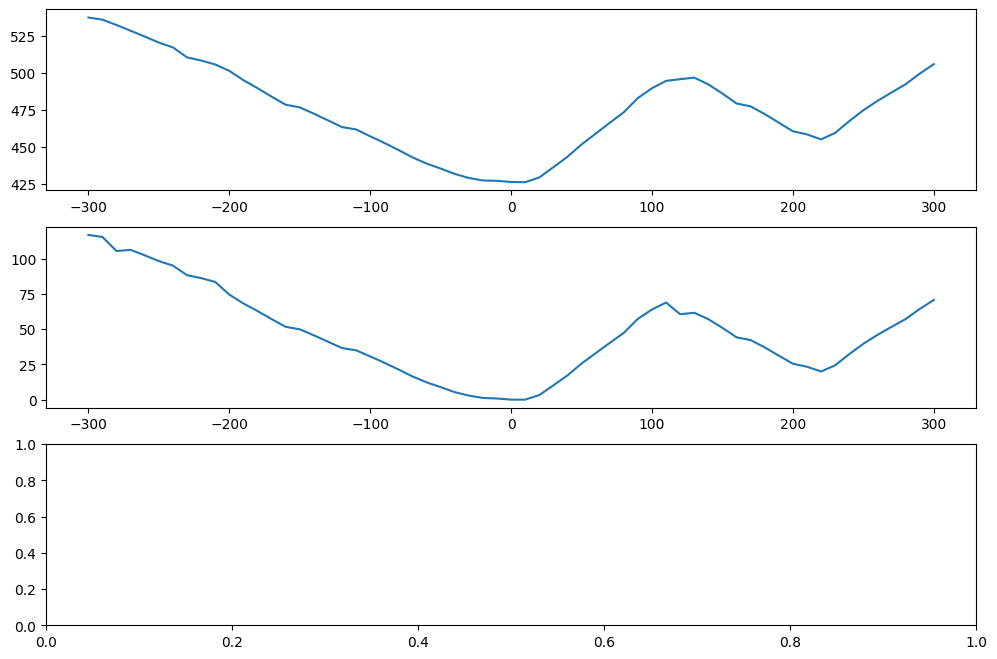

In [35]:
fig, ax = plt.subplots(3,1, figsize=(12,8))
points = subbasin_alternate.cross_sections_df.loc[subbasin_alternate.cross_sections_df['cross_section_id'] == 8]
#ax[0].scatter(points['alpha'], points['hand'])
ax[0].plot(points['alpha'], points['elevation'])
ax[1].plot(points['alpha'], points['hand'])